In [1]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt
# import root_numpy as rtnp

version_id = 'v2'
SEED = 42

Using TensorFlow backend.


### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [2]:
# get h5 datasets
data_path = "data/background/*_data.h5"
signal_path = "data/signal/*_data.h5"

data, data_tags, data_jets = utils.load_all_data(data_path, "background")
signal, signal_tags, signal_jets = utils.load_all_data(signal_path, "signal")

split = 0.25

train, test = data.train_test_split(split, SEED)
utils.compare_tags([train, test, data, signal])

data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")
train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")

norm_args = {"norm_type": "StandardScaler"}
train_norm, test_norm = train_raw.norm(train_raw, **norm_args), train_raw.norm(test_raw, **norm_args)
data_norm, signal_norm = train_raw.norm(data_raw, **norm_args), train_raw.norm(signal_raw, **norm_args)

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

bottom:
	3.2% (2504) train
	3.2% (837) test
	3.2% (3341) background
	78.8% (38995) signal
up:
	37.4% (29023) train
	38.0% (9818) test
	37.6% (38841) background
	3.8% (1866) signal
down:
	18.4% (14251) train
	18.4% (4748) test
	18.4% (18999) background
	2.5% (1220) signal
strange:
	24.7% (19123) train
	24.2% (6254) test
	24.5% (25377) background
	3.1% (1550) signal
charm:
	9.2% (7151) train
	9.4% (2426) test
	9.3% (9577) background
	6.8% (3344) signal
gluon:
	7.1% (5510) train
	6.9% (1771) test
	7.0% (7281) background
	5.1% (2541) signal


data_table :: plotting distrubution(s) for table(s) ['jet 0 background', 'jet 1 background', 'jet 0 signal', 'jet 1 signal']


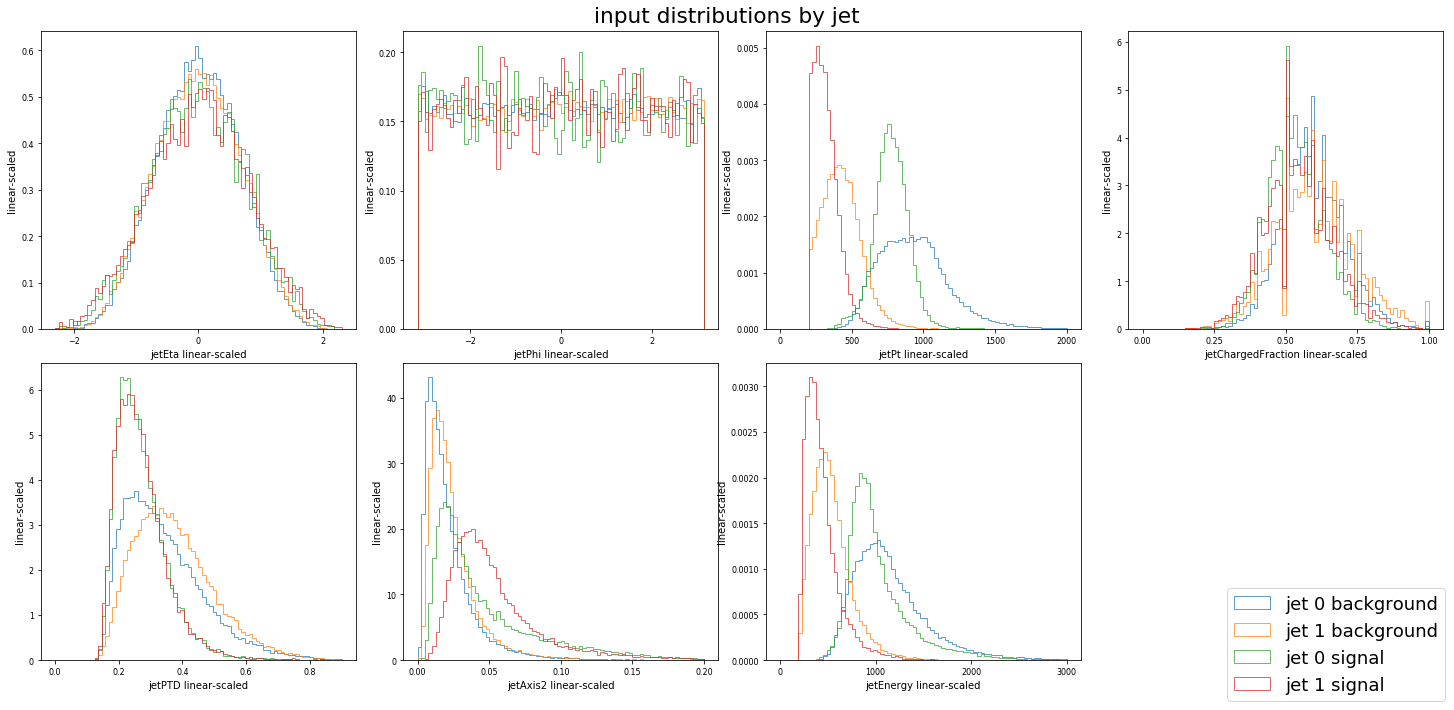

In [18]:
data_jets_raw = [d.cfilter(data_raw.headers) for d in data_jets]
signal_jets_raw = [d.cfilter(data_raw.headers) for d in signal_jets]

data_jets_raw[0].plot(
    data_jets_raw[1:] + signal_jets_raw,
    normed=1, figname="input distributions by jet", 
    bins=80, figsize=20,
    rng=[(-2.3, 2.3), (-np.pi, np.pi), (0., 2000.), (0., 1.), (0., 0.9), (0., 0.2), (0, 3000)]
)

In [4]:
l1_amount = None          # l1 regularization amount
# KL_loss_weight = 1.8      # according to olmo's paper
input_dim = 7              # num. HLF
interm_dim = 20            # num. interm nodes
neck_dim = 1             # num. latent variables
kernel_max_norm = None     # kernel max norm amount
learning_rate = 0.0001

name = "custom_loss_{0}_{1}".format(neck_dim, version_id)
repo_head = utils.get_repo_info()['head']
model_path = repo_head + "/autoencode/data/training_runs/"

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [5]:
def ISRLU(args, min_value = 5e-3):
    """ranges from (0, +inf), with relu behavior at x > 0 and exponential decay at x < 0 (stolen from Olmo)"""
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1+K.square(args))))

class loss_layer(keras.layers.Layer):
    """Wrapper for recon. prob. function. 
    Outputs reconstruction probability of gaussians for vae
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(loss_layer, self).__init__(**kwargs)
    
    def call(self, inputs):
        x, mu, sigma = inputs
        return reconstruction_probability(x, mu, sigma)

def reconstruction_probability(x, mu, sigma):
    """calculate gaussian -log likelihood across all variables and sum"""
    z_score = K.tf.divide(x - mu, sigma)
    single = - K.log(1./(sigma*np.sqrt(2.*np.pi)))/np.log(np.e) + 0.5*K.square(z_score)
    return K.sum(single, axis=-1)

def identity(y_train, vae_output):
    """identity loss, takes into account ONLY the VAE output (vae output should actually be the 
    calculated loss functions!)"""
    return K.mean(vae_output)

def sum_of_gaussians(x, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

custom_objects = {
    "ISRLU": ISRLU,
    "loss_layer": loss_layer,
    "reconstruction_probability": reconstruction_probability,
    "identity": identity,
    "sum_of_gaussians": sum_of_gaussians,
}

In [6]:
input_layer = keras.layers.Input(shape=(input_dim,), name="input")

intermediate_layer_enc1 = keras.layers.Dense(interm_dim, name="hidden_enc_1")
intermediate_layer_enc2 = keras.layers.Dense(interm_dim, activation='relu', kernel_constraint=keras.constraints.max_norm(kernel_max_norm), name='hidden_enc_2')

neck_layer = keras.layers.Dense(neck_dim, name='neck')
neck_input_layer = keras.layers.Input(shape=(neck_dim,), name='neck_input')

intermediate_layer_dec1 = keras.layers.Dense(interm_dim, activation='relu', name="hidden_dec_1", kernel_constraint=keras.constraints.max_norm(kernel_max_norm))
intermediate_layer_dec2 = keras.layers.Dense(interm_dim, activation='relu', name="hidden_dec_2")

output_sigma_pre_layer = keras.layers.Dense(input_dim, name="output_sigma_pre", activation="linear")
output_sigma_layer = keras.layers.Lambda(ISRLU, name="output_sigma")
output_mu_layer = keras.layers.Dense(input_dim, name="output_mu", activation="linear")

In [7]:
enc = intermediate_layer_enc1(input_layer)
enc = intermediate_layer_enc2(enc)
neck = neck_layer(enc)

dec = intermediate_layer_dec1(neck_input_layer)
dec = intermediate_layer_dec2(dec)

output_sigma = output_sigma_layer(output_sigma_pre_layer(dec))
output_mu = output_mu_layer(dec)

encoder = keras.models.Model(inputs=input_layer, outputs=neck, name='encoder')
decoder = keras.models.Model(inputs=neck_input_layer, outputs=[output_mu, output_sigma], name='decoder')
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoder(encoder(input_layer)), name='autoencoder')

loss_output = loss_layer(name="loss_layer")([input_layer] + autoencoder(input_layer))
autoencoder_train = keras.models.Model(inputs=input_layer, outputs=loss_output, name='trae')

autoencoder_train.compile(
    optimizer=keras.optimizers.adam(lr=learning_rate),
    loss=[identity],
    loss_weights=[1.]
)
autoencoder_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 7)            0                                            
__________________________________________________________________________________________________
autoencoder (Model)             [(None, 7), (None, 7 6567        input[0][0]                      
__________________________________________________________________________________________________
loss_layer (loss_layer)         [(None, 7), (None, 7 0           input[0][0]                      
                                                                 autoencoder[1][0]                
                                                                 autoencoder[1][1]                
Total params: 6,567
Trainable params: 6,567
Non-trainable params: 0
_________________________________________

In [8]:
instance = trainer.trainer(os.path.join(model_path, name))

h5_elt 'metric_names' :: creating group 'data' in file 'custom_loss_3_v2.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'custom_loss_3_v2.h5'
h5_elt 'training' :: creating group 'params' in file 'custom_loss_3_v2.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'custom_loss_3_v2.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'custom_loss_3_v2.h5'


In [9]:
autoencoder_train = instance.load_model(custom_objects=custom_objects)

train_shell :: ERROR: no model passed and no saved model found!!


AttributeError: no model passed and no saved model found!!

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

training is easy:

In [28]:
autoencoder_train = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss=[identity],
    epochs=200,
    model=autoencoder_train,
    metrics=[],
    force=True,
    batch_size=128,
    use_callbacks=True,
    learning_rate=0.0001,
    custom_objects=custom_objects,
)

train_shell :: using model passed as function argument
Train on 77562 samples, validate on 25854 samples
Epoch 201/400
77562/77562 [==============================] - 2s 30us/step - loss: -9.2464 - val_loss: -9.2936
Epoch 202/400
77562/77562 [==============================] - 2s 24us/step - loss: -9.2707 - val_loss: -9.2815
Epoch 203/400
77562/77562 [==============================] - 2s 24us/step - loss: -9.2663 - val_loss: -9.2713
Epoch 204/400
77562/77562 [==============================] - 2s 24us/step - loss: -9.2719 - val_loss: -9.2414
Epoch 205/400
77562/77562 [==============================] - 2s 24us/step - loss: -9.2764 - val_loss: -9.2599
Epoch 206/400
77562/77562 [==============================] - 2s 25us/step - loss: -9.2706 - val_loss: -9.3024
Epoch 207/400
77562/77562 [==============================] - 2s 24us/step - loss: -9.2737 - val_loss: -9.2940
Epoch 208/400
77562/77562 [==============================] - 2s 24us/step - loss: -9.2846 - val_loss: -9.2331
Epoch 209/400
7

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

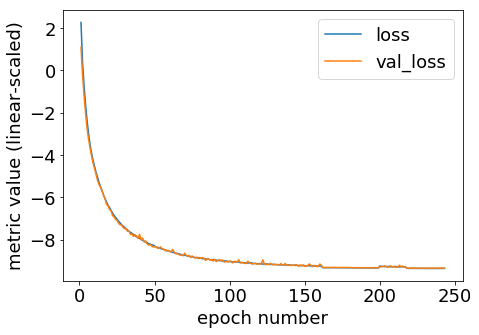

In [31]:
instance.plot_metrics(fnmatch_criteria="*loss", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

In [32]:
signal_jets_norm, data_jets_norm = [
    [train_raw.norm(j.cfilter(signal_norm.headers), **norm_args) for j in jet_table] for jet_table in [signal_jets, data_jets]
]

In [33]:
autoencoder = autoencoder_train.layers[1]
encoder, decoder = autoencoder.layers[1:]

nodenames = ["node {}".format(i+1) for i in range(neck_dim)]
data_reps, signal_reps = (
    utils.data_table(encoder.predict(data_norm.data), headers=nodenames, name="background_reps"),
    utils.data_table(encoder.predict(signal_norm.data), headers=nodenames, name="signal_reps")
)

data_jet_reps, signal_jet_reps = (
    [utils.data_table(encoder.predict(d.data), headers=nodenames, name="jet {} background reps".format(i)) for i,d in enumerate(data_jets_norm)],
    [utils.data_table(encoder.predict(d.data), headers=nodenames, name="jet {} signal reps".format(i)) for i,d in enumerate(signal_jets_norm)],
)

data_table :: plotting distrubution(s) for table(s) ['background_reps', 'signal_reps']


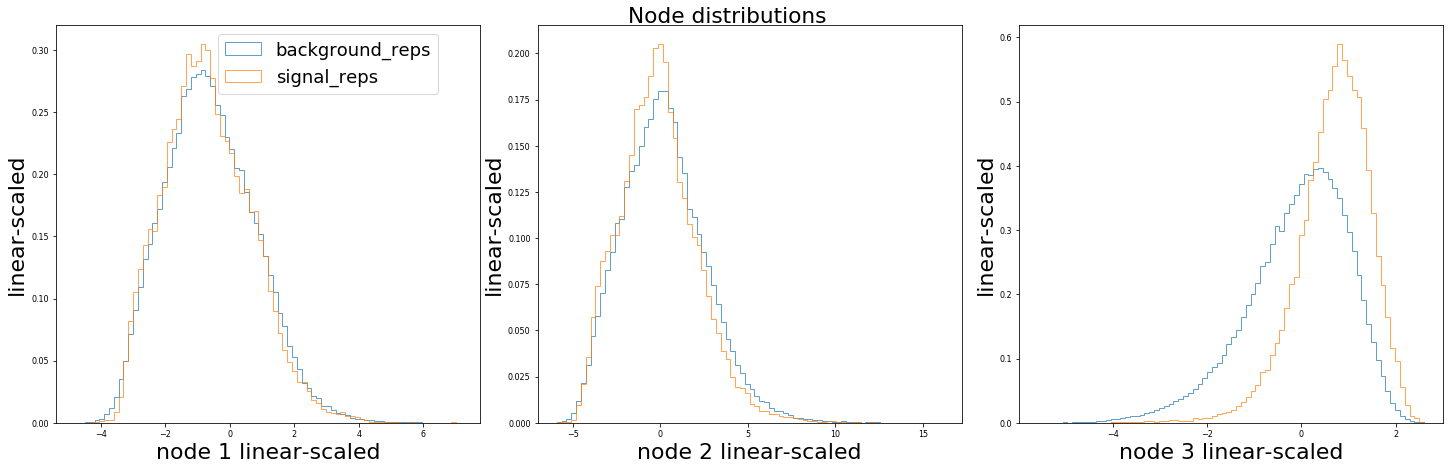

data_table :: plotting distrubution(s) for table(s) ['jet 0 background reps', 'jet 1 background reps', 'jet 0 signal reps', 'jet 1 signal reps']


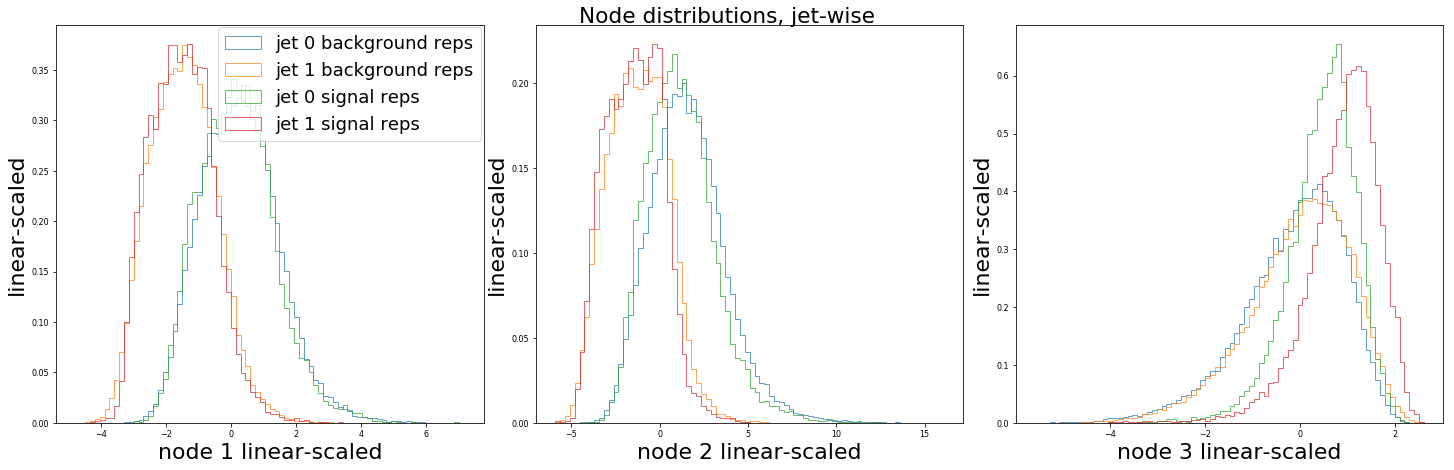

In [34]:
data_reps.plot([signal_reps], cols=5, figsize=20, fontsize=22, normed=1, bins=80, figname="Node distributions", figloc=(0.15,0.8))
data_jet_reps[0].plot(data_jet_reps[1:] + signal_jet_reps, cols=5, figsize=20, fontsize=22, normed=1, bins=80, figname="Node distributions, jet-wise", figloc=(0.15,0.7))

In [35]:
data_outputs = autoencoder.predict(data_norm.data)
signal_outputs = autoencoder.predict(signal_norm.data)

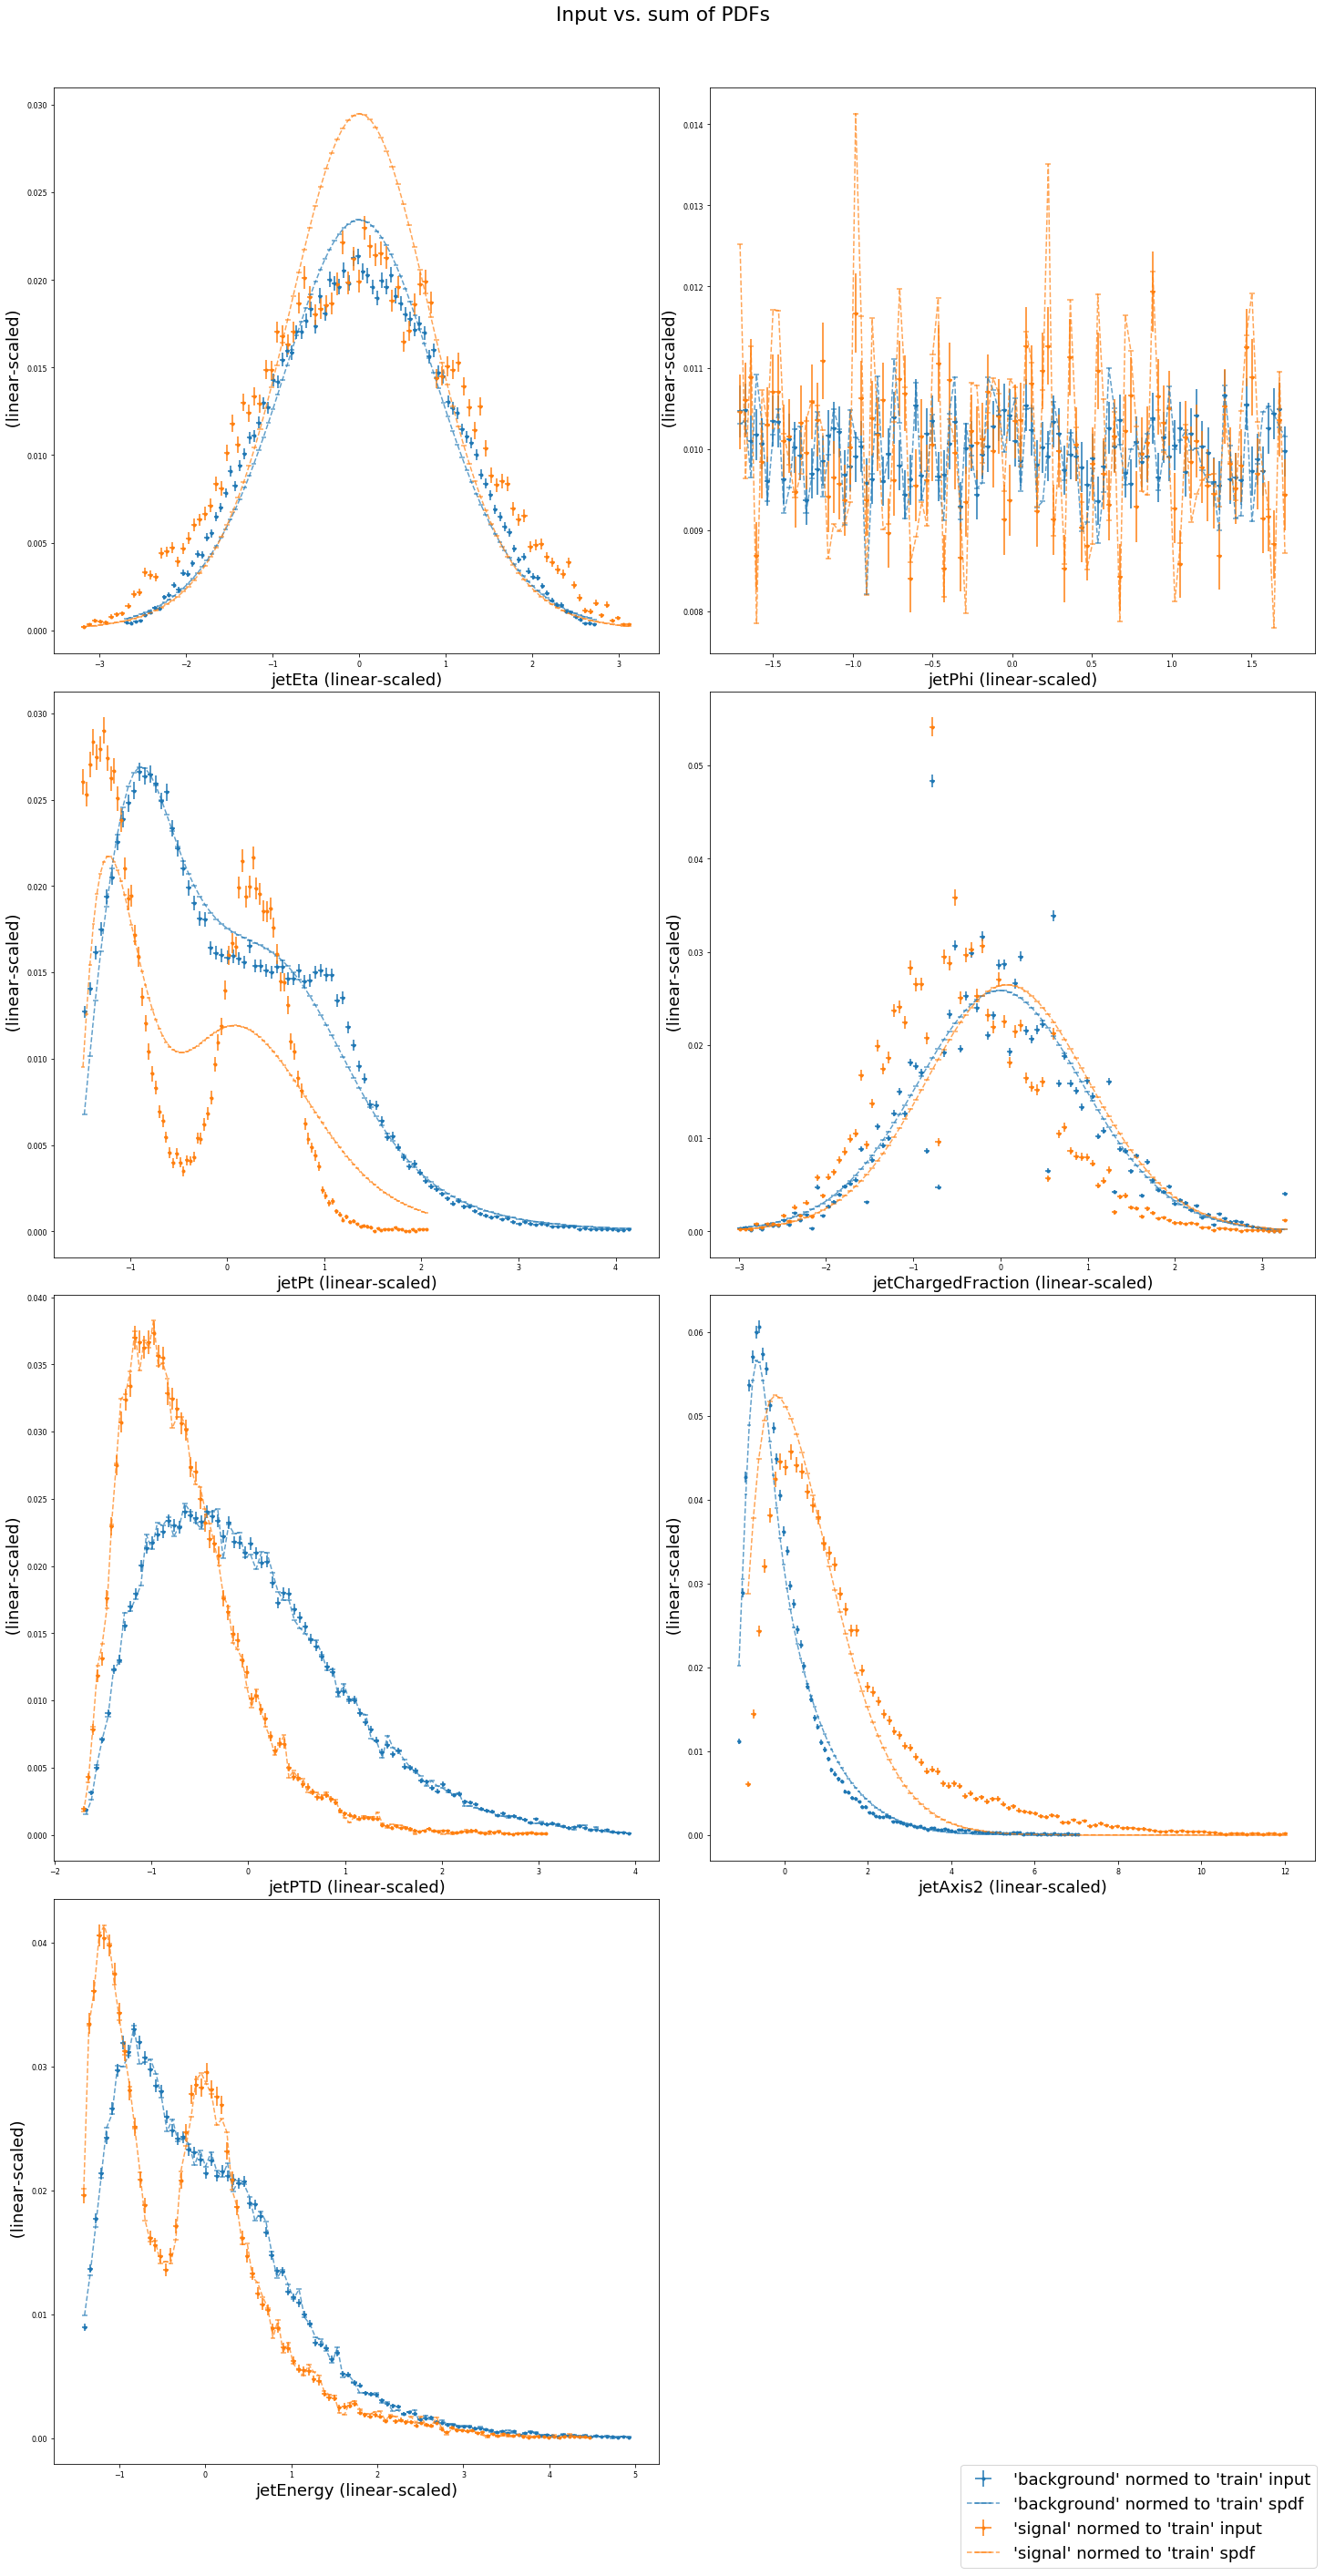

In [36]:
utils.plot_spdfs([data_norm, signal_norm], [data_outputs, signal_outputs], cols=2, figname="Input vs. sum of PDFs")

In [37]:
err_data = utils.data_table(np.expand_dims(autoencoder_train.predict(data_norm.data), 1), headers=['loss'], name='combined data error')
err_signal = utils.data_table(np.expand_dims(autoencoder_train.predict(signal_norm.data), 1), headers=['loss'], name='combined signal error')
err_data_jets = [
    utils.data_table(
        np.expand_dims(autoencoder_train.predict(d.data), 1),
        headers=['loss'],
        name='jet {} background error'.format(i + 1)
    ) for i,d in enumerate(data_jets_norm)
]

err_signal_jets = [
    utils.data_table(
        np.expand_dims(autoencoder_train.predict(d.data), 1),
        headers=['loss'],
        name='jet {} signal error'.format(i + 1)
    ) for i,d in enumerate(signal_jets_norm)
]

data_table :: plotting distrubution(s) for table(s) ['jet 1 signal error', 'jet 2 signal error', 'jet 1 background error', 'jet 2 background error']


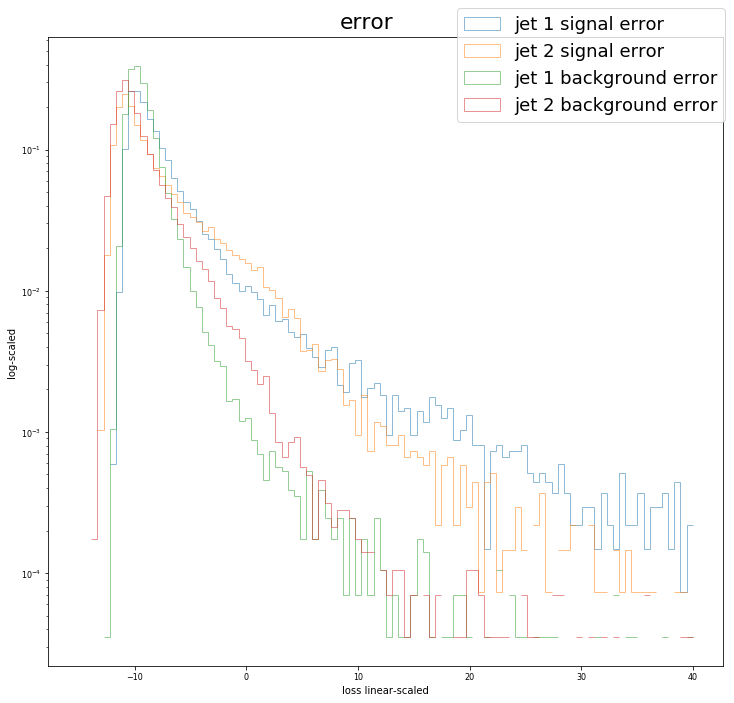

In [45]:
err_signal_jets[0].plot(
    err_signal_jets[1:] + err_data_jets, bins=100, normed=1, yscale='log',
    figsize=(10,10), alpha=1.5, rng=(-15, 40), figloc="upper right",
    figname="error"
)

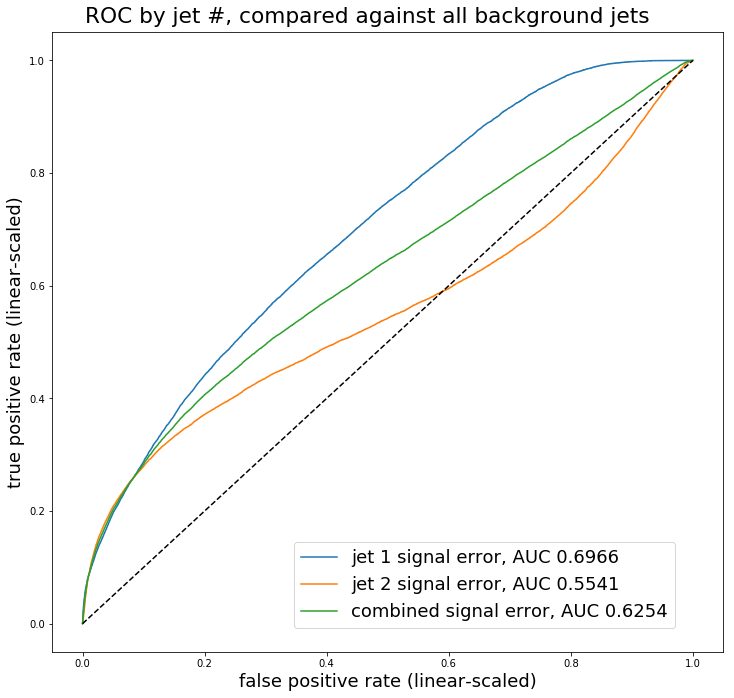

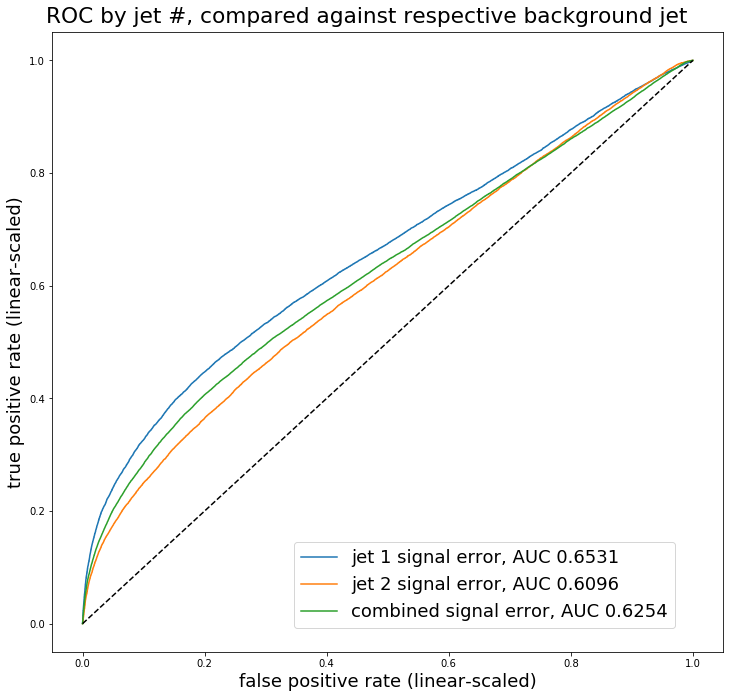

In [39]:
utils.roc_auc_plot([err_data], err_signal_jets + [err_signal], ticksize=10, yscale='linear', figsize=10, figloc=(.4, .10), figname="ROC by jet #, compared against all background jets")
utils.roc_auc_plot(err_data_jets + [err_data], err_signal_jets + [err_signal], ticksize=10, yscale='linear', figsize=10, figloc=(.4, .10), figname="ROC by jet #, compared against respective background jet")